In [5]:
import os
import sys
import pathlib
from matplotlib import pyplot as plt
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils.conversions import angle_axis_to_rotation_matrix
import numpy as np
import matplotlib.pyplot as plt
from data_loader.data_loaders import SingleDataset
from model.deepvo.deepvo_model import DeepVOModel
from utils.conversions import se3_exp_map, quaternion_to_rotation_matrix
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:

def plot_route(trajectories = None, labels = None, colors = None):
    '''Plots the trajectory of the robot in 3D space
    Args:
        trajectories (list): list of trajectories to plot
        labels (list): list of labels for each trajectory,
        colors (list): list of colors for each trajectory
        '''    
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    ax1 = fig.add_subplot(231)
    ax2 = fig.add_subplot(234)
    ax3 = fig.add_subplot(232)
    for trajectory, label, color in zip(trajectories, labels, colors):
        trajectory = torch.stack(trajectory).view(len(trajectory),4,4).cpu().detach().numpy()
        x = trajectory[:][:,0,3]  
        y = trajectory[:][:,1,3]
        z = trajectory[:][:,2,3]
        a1 = ax1.plot(x, y, color=color, label=label)
        plt.xlabel("X")
        plt.ylabel("Y")
        a2 = ax2.plot(x, z, color=color, label=label)
        plt.xlabel("X")
        plt.ylabel("Z")
        a3 = ax3.plot(y, z, color=color, label=label)
        plt.xlabel("Y")
        plt.ylabel("Z")
    fig.legend([a1, a2, a3],     # The line objects
           labels=labels,   # The labels for each line
           loc="lower right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="Legend Title"  # Title for the legend
           )
    plt.show()


In [3]:

def to_device(data, device):
    if isinstance(data, dict):
        return {k: to_device(data[k], device) for k in data.keys()}
    elif isinstance(data, list):
        return [to_device(v, device) for v in data]
    else:
        return data.to(device)

def relative_to_absolute_pose(poses):
    '''Converts relative poses to absolute poses
    Args:
        poses (list): list of relative poses
    Returns:
        list: list of absolute poses
    '''
    absolute_poses = []
    for i,relative_pose in enumerate(poses):
        if i==0:
            absolute_poses.append(relative_pose)
            continue
        last_absolute_pose = absolute_poses[-1]
        absolute_poses.append(torch.matmul(last_absolute_pose, relative_pose))
    return absolute_poses


In [7]:

# Load the data
test_sequence='09'
cfg_dir=os.path.join(os.getcwd(),"..","configs","data_loader","KITTI", test_sequence, test_sequence+".yml")
data_loader = DataLoader(SingleDataset(cfg_dir),batch_size=1, shuffle=False, num_workers=0, drop_last=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


100%|██████████| 1589/1589 [01:33<00:00, 16.99it/s]
/tmp/ipykernel_3908050/133649351.py:27: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([a1, a2, a3],     # The line objects


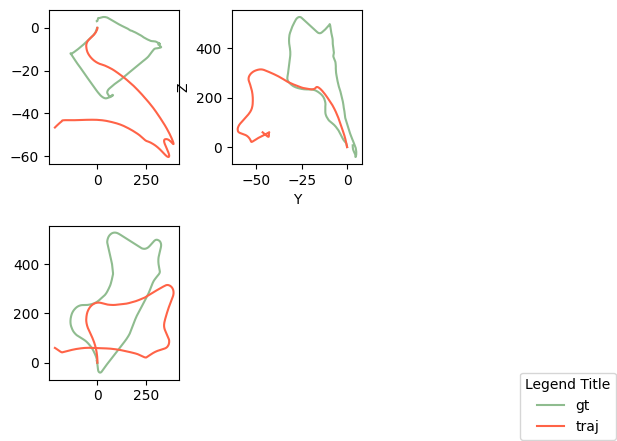

In [22]:
the_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_se3/original_paper/weighted", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
# Some auxiliary variables
the_relative = list()  
T_target_relative = list()

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = the_model(data)
                target = data["poses"]
                deepvo_estimate = deepvo_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. angle axis rotations)
                # the_rel = angle_axis_to_rotation_matrix(deepvo_estimate[:, 1, :3])            
                # the_rel[:,0:3,3] = deepvo_estimate[:,1,-3:]
                # for deepvo (w. se3 rotations)
                T_estimate_se3_rel = se3_exp_map(deepvo_estimate[:, 0, :6])
                the_relative.append(T_estimate_se3_rel)
                # for deepvo (w. quaternion rotations)
                # T_estimate_quat_rel = torch.eye((4)).reshape(1,4,4)
                # q_rotation = quaternion_to_rotation_matrix(deepvo_estimate[:, 0, 3:])
                # T_estimate_quat_rel[:,:3,:3] = q_rotation
                # T_estimate_quat_rel[:,0:3,3] = deepvo_estimate[:,0,:3]
                # the_relative.append(T_estimate_quat_rel)

        
       
T_target_absolute = relative_to_absolute_pose(T_target_relative)
the_absolute = relative_to_absolute_pose(the_relative)
plot_route(trajectories=[T_target_absolute,the_absolute], 
           colors=['darkseagreen', 'tomato'], labels=['gt','traj'])  

100%|██████████| 1589/1589 [01:31<00:00, 17.31it/s]
/tmp/ipykernel_3908050/133649351.py:27: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([a1, a2, a3],     # The line objects


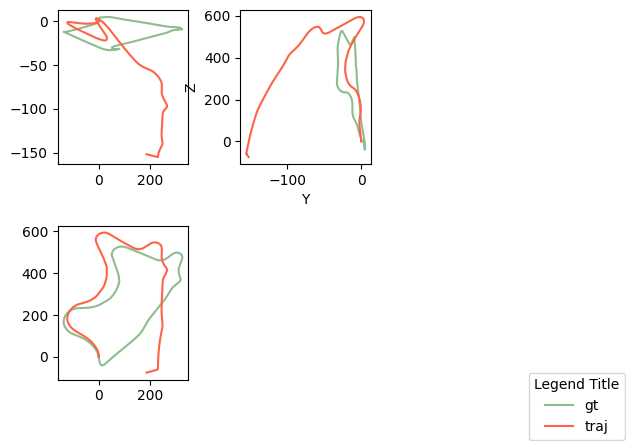

In [21]:
the_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_se3/original_paper/weighted", "checkpoint-last.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
# Some auxiliary variables
the_relative = list()  
T_target_relative = list()

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = the_model(data)
                target = data["poses"]
                deepvo_estimate = deepvo_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. angle axis rotations)
                # the_rel = angle_axis_to_rotation_matrix(deepvo_estimate[:, 1, :3])            
                # the_rel[:,0:3,3] = deepvo_estimate[:,1,-3:]
                # for deepvo (w. se3 rotations)
                T_estimate_se3_rel = se3_exp_map(deepvo_estimate[:, 0, :6])
                the_relative.append(T_estimate_se3_rel)
                # for deepvo (w. quaternion rotations)
                # T_estimate_quat_rel = torch.eye((4)).reshape(1,4,4)
                # q_rotation = quaternion_to_rotation_matrix(deepvo_estimate[:, 0, 3:])
                # T_estimate_quat_rel[:,:3,:3] = q_rotation
                # T_estimate_quat_rel[:,0:3,3] = deepvo_estimate[:,0,:3]
                # the_relative.append(T_estimate_quat_rel)

        
T_target_absolute = relative_to_absolute_pose(T_target_relative)
the_absolute = relative_to_absolute_pose(the_relative)
plot_route(trajectories=[T_target_absolute,the_absolute], 
           colors=['darkseagreen', 'tomato'], labels=['gt','traj'])  


In [8]:
the_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_se3/original_paper/weighted/newseq", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
# Some auxiliary variables
the_relative = list()  
T_target_relative = list()

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = the_model(data)
                target = data["poses"]
                deepvo_estimate = deepvo_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. angle axis rotations)
                # the_rel = angle_axis_to_rotation_matrix(deepvo_estimate[:, 1, :3])            
                # the_rel[:,0:3,3] = deepvo_estimate[:,1,-3:]
                # for deepvo (w. se3 rotations)
                T_estimate_se3_rel = se3_exp_map(deepvo_estimate[:, 0, :6])
                the_relative.append(T_estimate_se3_rel)
                # for deepvo (w. quaternion rotations)
                # T_estimate_quat_rel = torch.eye((4)).reshape(1,4,4)
                # q_rotation = quaternion_to_rotation_matrix(deepvo_estimate[:, 0, 3:])
                # T_estimate_quat_rel[:,:3,:3] = q_rotation
                # T_estimate_quat_rel[:,0:3,3] = deepvo_estimate[:,0,:3]
                # the_relative.append(T_estimate_quat_rel)

        
T_target_absolute = relative_to_absolute_pose(T_target_relative)
the_absolute = relative_to_absolute_pose(the_relative)
plot_route(trajectories=[T_target_absolute,the_absolute], 
           colors=['darkseagreen', 'tomato'], labels=['gt','traj'])  


 69%|██████▉   | 1093/1589 [01:25<00:36, 13.68it/s]

100%|██████████| 1589/1589 [01:57<00:00, 13.47it/s]
/tmp/ipykernel_3908050/133649351.py:27: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([a1, a2, a3],     # The line objects


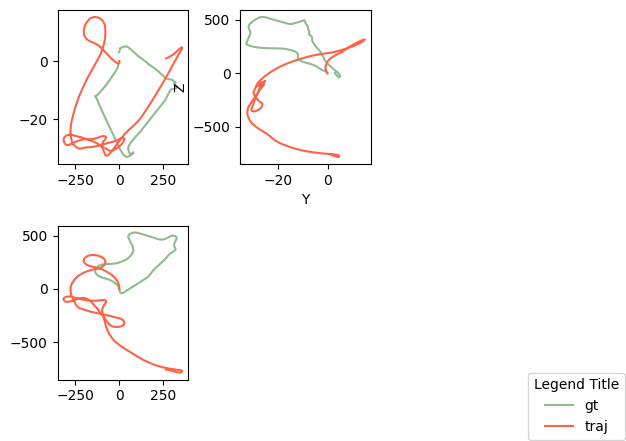

In [24]:
the_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo/original_paper/flownetS", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
# Some auxiliary variables
the_relative = list()  
T_target_relative = list()

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = the_model(data)
                target = data["poses"]
                deepvo_estimate = deepvo_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. angle axis rotations)
                the_rel = angle_axis_to_rotation_matrix(deepvo_estimate[:, 1, :3])            
                the_rel[:,0:3,3] = deepvo_estimate[:,1,-3:]
                the_relative.append(the_rel)
                # for deepvo (w. se3 rotations)
                # T_estimate_se3_rel = se3_exp_map(deepvo_estimate[:, 0, :6])
                # the_relative.append(T_estimate_se3_rel)
                # for deepvo (w. quaternion rotations)
                # T_estimate_quat_rel = torch.eye((4)).reshape(1,4,4)
                # q_rotation = quaternion_to_rotation_matrix(deepvo_estimate[:, 0, 3:])
                # T_estimate_quat_rel[:,:3,:3] = q_rotation
                # T_estimate_quat_rel[:,0:3,3] = deepvo_estimate[:,0,:3]
                # the_relative.append(T_estimate_quat_rel)

        
T_target_absolute = relative_to_absolute_pose(T_target_relative)
the_absolute = relative_to_absolute_pose(the_relative)
plot_route(trajectories=[T_target_absolute,the_absolute], 
           colors=['darkseagreen', 'tomato'], labels=['gt','traj'])  


100%|██████████| 1589/1589 [01:56<00:00, 13.62it/s]
/tmp/ipykernel_3908050/133649351.py:27: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([a1, a2, a3],     # The line objects


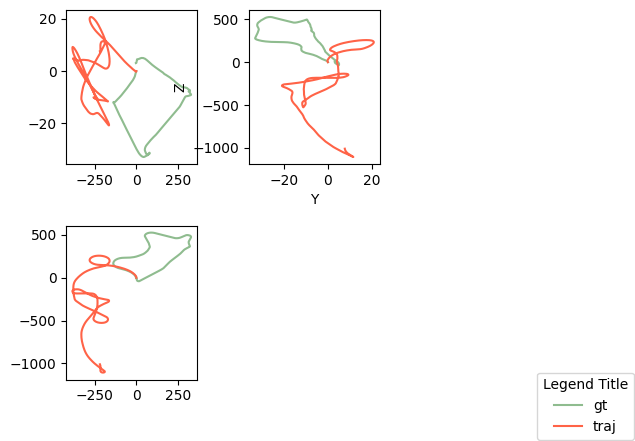

In [25]:
the_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo/original_paper/flownetS", "checkpoint-last.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
# Some auxiliary variables
the_relative = list()  
T_target_relative = list()

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = the_model(data)
                target = data["poses"]
                deepvo_estimate = deepvo_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. angle axis rotations)
                the_rel = angle_axis_to_rotation_matrix(deepvo_estimate[:, 1, :3])            
                the_rel[:,0:3,3] = deepvo_estimate[:,1,-3:]
                the_relative.append(the_rel)
                # for deepvo (w. se3 rotations)
                # T_estimate_se3_rel = se3_exp_map(deepvo_estimate[:, 0, :6])
                # the_relative.append(T_estimate_se3_rel)
                # for deepvo (w. quaternion rotations)
                # T_estimate_quat_rel = torch.eye((4)).reshape(1,4,4)
                # q_rotation = quaternion_to_rotation_matrix(deepvo_estimate[:, 0, 3:])
                # T_estimate_quat_rel[:,:3,:3] = q_rotation
                # T_estimate_quat_rel[:,0:3,3] = deepvo_estimate[:,0,:3]
                # the_relative.append(T_estimate_quat_rel)

        
T_target_absolute = relative_to_absolute_pose(T_target_relative)
the_absolute = relative_to_absolute_pose(the_relative)
plot_route(trajectories=[T_target_absolute,the_absolute], 
           colors=['darkseagreen', 'tomato'], labels=['gt','traj'])  


100%|██████████| 1589/1589 [02:46<00:00,  9.55it/s]
/tmp/ipykernel_3911435/133649351.py:27: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([a1, a2, a3],     # The line objects


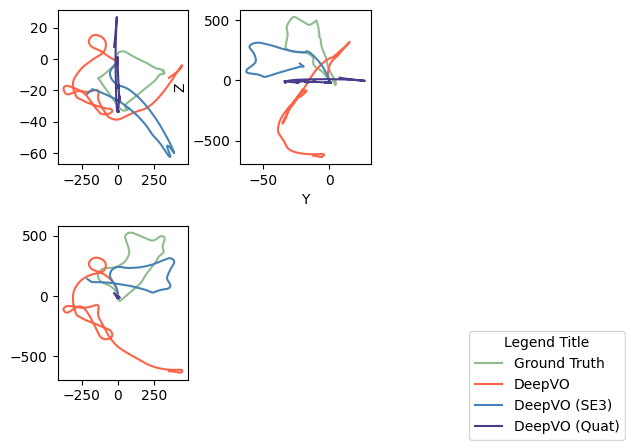

In [5]:

# Load the data
test_sequence='09'
cfg_dir=os.path.join(os.getcwd(),"..","configs","data_loader","KITTI", test_sequence, test_sequence+".yml")
data_loader = DataLoader(SingleDataset(cfg_dir),batch_size=1, shuffle=False, num_workers=0, drop_last=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model
deepvo_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo/original_paper/flownetS", "best-checkpoint-epoch.pth")],
                    conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                    image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
deepvo_se3_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_se3/original_paper/weighted", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
deepvo_quat_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_quat/original_paper/flownetS", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 7, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
# Some auxiliary variables
T_target_relative = list()  

T_deepvo_relative = list()
T_deepvo_se3_relative = list()
T_deepvo_quat_relative = list()

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = deepvo_model(data)

                target = data["poses"]
                deepvo_estimate = deepvo_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. angle axis rotations)
                T_estimate_rel = angle_axis_to_rotation_matrix(deepvo_estimate[:, 1, :3])            
                T_estimate_rel[:,0:3,3] = deepvo_estimate[:,1,-3:]
                T_deepvo_relative.append(T_estimate_rel)
                

        
T_target_absolute = relative_to_absolute_pose(T_target_relative)
T_deepvo_absolute = relative_to_absolute_pose(T_deepvo_relative)

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch

                deepvo_se3_outputs = deepvo_se3_model(data)

                target = data["poses"]
                deepvo_se3_estimate = deepvo_se3_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. se3 rotations)
                T_estimate_se3_rel = se3_exp_map(deepvo_se3_estimate[:, 0, :6])
                T_deepvo_se3_relative.append(T_estimate_se3_rel)

        
T_deepvo_se3_absolute = relative_to_absolute_pose(T_deepvo_se3_relative)

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = deepvo_model(data)
                deepvo_se3_outputs = deepvo_se3_model(data)
                deepvo_quat_outputs = deepvo_quat_model(data)

                target = data["poses"]
                deepvo_quat_estimate = deepvo_quat_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
            
                # for deepvo (w. quaternion rotations)
                T_estimate_quat_rel = torch.eye((4)).reshape(1,4,4)
                q_rotation = quaternion_to_rotation_matrix(deepvo_quat_estimate[:, 0, 3:])
                T_estimate_quat_rel[:,:3,:3] = q_rotation
                T_estimate_quat_rel[:,0:3,3] = deepvo_quat_estimate[:,0,:3]
                T_deepvo_quat_relative.append(T_estimate_quat_rel)

        

T_deepvo_quat_absolute = relative_to_absolute_pose(T_deepvo_quat_relative)
    
plot_route(trajectories=[T_target_absolute, T_deepvo_absolute, T_deepvo_se3_absolute, T_deepvo_quat_absolute], 
           colors=['darkseagreen', 'tomato', 'steelblue', 'darkslateblue'], labels=['Ground Truth', 'DeepVO', 'DeepVO (SE3)', 'DeepVO (Quat)'])           
     

100%|██████████| 1099/1099 [01:56<00:00,  9.42it/s]
/tmp/ipykernel_3911435/133649351.py:27: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([a1, a2, a3],     # The line objects


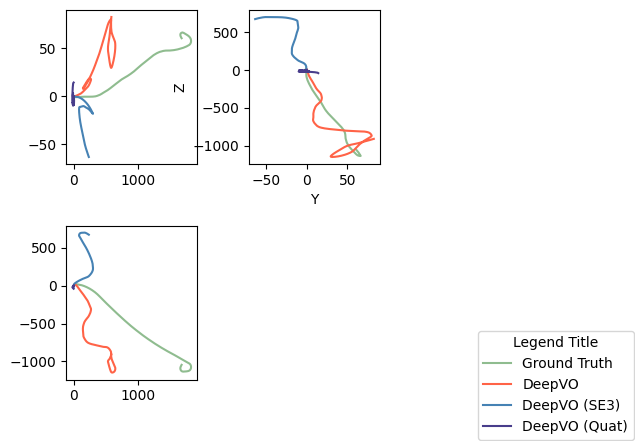

In [6]:

# Load the data
test_sequence='01'
cfg_dir=os.path.join(os.getcwd(),"..","configs","data_loader","KITTI", test_sequence, test_sequence+".yml")
data_loader = DataLoader(SingleDataset(cfg_dir),batch_size=1, shuffle=False, num_workers=0, drop_last=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model
deepvo_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo/original_paper/flownetS", "best-checkpoint-epoch.pth")],
                    conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                    image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
deepvo_se3_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_se3/original_paper/weighted", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
deepvo_quat_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_quat/original_paper/flownetS", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 7, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
# Some auxiliary variables
T_target_relative = list()  

T_deepvo_relative = list()
T_deepvo_se3_relative = list()
T_deepvo_quat_relative = list()

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = deepvo_model(data)

                target = data["poses"]
                deepvo_estimate = deepvo_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. angle axis rotations)
                T_estimate_rel = angle_axis_to_rotation_matrix(deepvo_estimate[:, 1, :3])            
                T_estimate_rel[:,0:3,3] = deepvo_estimate[:,1,-3:]
                T_deepvo_relative.append(T_estimate_rel)
                

        
T_target_absolute = relative_to_absolute_pose(T_target_relative)
T_deepvo_absolute = relative_to_absolute_pose(T_deepvo_relative)

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch

                deepvo_se3_outputs = deepvo_se3_model(data)

                target = data["poses"]
                deepvo_se3_estimate = deepvo_se3_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. se3 rotations)
                T_estimate_se3_rel = se3_exp_map(deepvo_se3_estimate[:, 0, :6])
                T_deepvo_se3_relative.append(T_estimate_se3_rel)

        
T_deepvo_se3_absolute = relative_to_absolute_pose(T_deepvo_se3_relative)

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = deepvo_model(data)
                deepvo_se3_outputs = deepvo_se3_model(data)
                deepvo_quat_outputs = deepvo_quat_model(data)

                target = data["poses"]
                deepvo_quat_estimate = deepvo_quat_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
            
                # for deepvo (w. quaternion rotations)
                T_estimate_quat_rel = torch.eye((4)).reshape(1,4,4)
                q_rotation = quaternion_to_rotation_matrix(deepvo_quat_estimate[:, 0, 3:])
                T_estimate_quat_rel[:,:3,:3] = q_rotation
                T_estimate_quat_rel[:,0:3,3] = deepvo_quat_estimate[:,0,:3]
                T_deepvo_quat_relative.append(T_estimate_quat_rel)

        

T_deepvo_quat_absolute = relative_to_absolute_pose(T_deepvo_quat_relative)
    
plot_route(trajectories=[T_target_absolute, T_deepvo_absolute, T_deepvo_se3_absolute, T_deepvo_quat_absolute], 
           colors=['darkseagreen', 'tomato', 'steelblue', 'darkslateblue'], labels=['Ground Truth', 'DeepVO', 'DeepVO (SE3)', 'DeepVO (Quat)'])           
     


100%|██████████| 1099/1099 [01:54<00:00,  9.61it/s]
/tmp/ipykernel_3913280/133649351.py:27: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([a1, a2, a3],     # The line objects


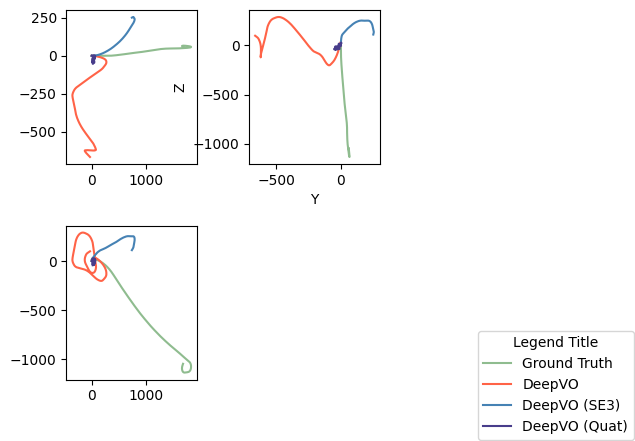

In [11]:

# Load the data
test_sequence='01'
cfg_dir=os.path.join(os.getcwd(),"..","configs","data_loader","KITTI", test_sequence, test_sequence+".yml")
data_loader = DataLoader(SingleDataset(cfg_dir),batch_size=1, shuffle=False, num_workers=0, drop_last=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model
deepvo_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo/original_paper", "best-checkpoint-epoch.pth")],
                    conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                    image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
deepvo_se3_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_se3/original_paper/weighted/flownetS", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
deepvo_quat_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_quat/original_paper", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 7, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
# Some auxiliary variables
T_target_relative = list()  

T_deepvo_relative = list()
T_deepvo_se3_relative = list()
T_deepvo_quat_relative = list()

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = deepvo_model(data)

                target = data["poses"]
                deepvo_estimate = deepvo_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. angle axis rotations)
                T_estimate_rel = angle_axis_to_rotation_matrix(deepvo_estimate[:, 1, :3])            
                T_estimate_rel[:,0:3,3] = deepvo_estimate[:,1,-3:]
                T_deepvo_relative.append(T_estimate_rel)
                

        
T_target_absolute = relative_to_absolute_pose(T_target_relative)
T_deepvo_absolute = relative_to_absolute_pose(T_deepvo_relative)

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch

                deepvo_se3_outputs = deepvo_se3_model(data)

                target = data["poses"]
                deepvo_se3_estimate = deepvo_se3_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. se3 rotations)
                T_estimate_se3_rel = se3_exp_map(deepvo_se3_estimate[:, 0, :6])
                T_deepvo_se3_relative.append(T_estimate_se3_rel)

        
T_deepvo_se3_absolute = relative_to_absolute_pose(T_deepvo_se3_relative)

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = deepvo_model(data)
                deepvo_se3_outputs = deepvo_se3_model(data)
                deepvo_quat_outputs = deepvo_quat_model(data)

                target = data["poses"]
                deepvo_quat_estimate = deepvo_quat_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
            
                # for deepvo (w. quaternion rotations)
                T_estimate_quat_rel = torch.eye((4)).reshape(1,4,4)
                q_rotation = quaternion_to_rotation_matrix(deepvo_quat_estimate[:, 0, 3:])
                T_estimate_quat_rel[:,:3,:3] = q_rotation
                T_estimate_quat_rel[:,0:3,3] = deepvo_quat_estimate[:,0,:3]
                T_deepvo_quat_relative.append(T_estimate_quat_rel)

        

T_deepvo_quat_absolute = relative_to_absolute_pose(T_deepvo_quat_relative)
    
plot_route(trajectories=[T_target_absolute, T_deepvo_absolute, T_deepvo_se3_absolute, T_deepvo_quat_absolute], 
           colors=['darkseagreen', 'tomato', 'steelblue', 'darkslateblue'], labels=['Ground Truth', 'DeepVO', 'DeepVO (SE3)', 'DeepVO (Quat)'])           
     


In [13]:

# Load the data
test_sequence='02'
cfg_dir=os.path.join(os.getcwd(),"..","configs","data_loader","KITTI", test_sequence, test_sequence+".yml")
data_loader = DataLoader(SingleDataset(cfg_dir),batch_size=1, shuffle=False, num_workers=0, drop_last=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model
deepvo_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo/original_paper/flownetS", "best-checkpoint-epoch.pth")],
                    conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                    image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
deepvo_se3_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_se3/original_paper/weighted", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
deepvo_quat_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_quat/original_paper/flownetS", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 7, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
# Some auxiliary variables
T_target_relative = list()  

T_deepvo_relative = list()
T_deepvo_se3_relative = list()
T_deepvo_quat_relative = list()

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = deepvo_model(data)

                target = data["poses"]
                deepvo_estimate = deepvo_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. angle axis rotations)
                T_estimate_rel = angle_axis_to_rotation_matrix(deepvo_estimate[:, 1, :3])            
                T_estimate_rel[:,0:3,3] = deepvo_estimate[:,1,-3:]
                T_deepvo_relative.append(T_estimate_rel)
                

        
T_target_absolute = relative_to_absolute_pose(T_target_relative)
T_deepvo_absolute = relative_to_absolute_pose(T_deepvo_relative)

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch

                deepvo_se3_outputs = deepvo_se3_model(data)

                target = data["poses"]
                deepvo_se3_estimate = deepvo_se3_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. se3 rotations)
                T_estimate_se3_rel = se3_exp_map(deepvo_se3_estimate[:, 0, :6])
                T_deepvo_se3_relative.append(T_estimate_se3_rel)

        
T_deepvo_se3_absolute = relative_to_absolute_pose(T_deepvo_se3_relative)

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = deepvo_model(data)
                deepvo_se3_outputs = deepvo_se3_model(data)
                deepvo_quat_outputs = deepvo_quat_model(data)

                target = data["poses"]
                deepvo_quat_estimate = deepvo_quat_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
            
                # for deepvo (w. quaternion rotations)
                T_estimate_quat_rel = torch.eye((4)).reshape(1,4,4)
                q_rotation = quaternion_to_rotation_matrix(deepvo_quat_estimate[:, 0, 3:])
                T_estimate_quat_rel[:,:3,:3] = q_rotation
                T_estimate_quat_rel[:,0:3,3] = deepvo_quat_estimate[:,0,:3]
                T_deepvo_quat_relative.append(T_estimate_quat_rel)

        

T_deepvo_quat_absolute = relative_to_absolute_pose(T_deepvo_quat_relative)
    
plot_route(trajectories=[T_target_absolute, T_deepvo_absolute, T_deepvo_se3_absolute, T_deepvo_quat_absolute], 
           colors=['darkseagreen', 'tomato', 'steelblue', 'darkslateblue'], labels=['Ground Truth', 'DeepVO', 'DeepVO (SE3)', 'DeepVO (Quat)'])           
     


 56%|█████▋    | 2622/4659 [04:42<03:44,  9.05it/s]

100%|██████████| 799/799 [01:25<00:00,  9.38it/s]
/tmp/ipykernel_3913280/133649351.py:27: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([a1, a2, a3],     # The line objects


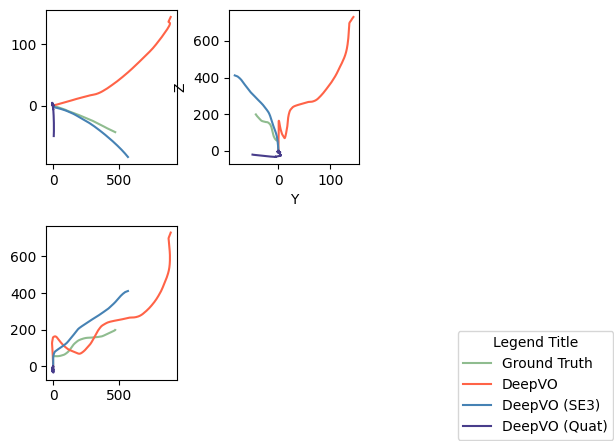

In [4]:

# Load the data
test_sequence='03'
cfg_dir=os.path.join(os.getcwd(),"..","configs","data_loader","KITTI", test_sequence, test_sequence+".yml")
data_loader = DataLoader(SingleDataset(cfg_dir),batch_size=1, shuffle=False, num_workers=0, drop_last=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model
deepvo_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo/original_paper/flownetS", "best-checkpoint-epoch.pth")],
                    conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                    image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
deepvo_se3_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_se3/original_paper/weighted", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
deepvo_quat_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_quat/original_paper/flownetS", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 7, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
# Some auxiliary variables
T_target_relative = list()  

T_deepvo_relative = list()
T_deepvo_se3_relative = list()
T_deepvo_quat_relative = list()

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = deepvo_model(data)

                target = data["poses"]
                deepvo_estimate = deepvo_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. angle axis rotations)
                T_estimate_rel = angle_axis_to_rotation_matrix(deepvo_estimate[:, 1, :3])            
                T_estimate_rel[:,0:3,3] = deepvo_estimate[:,1,-3:]
                T_deepvo_relative.append(T_estimate_rel)
                

        
T_target_absolute = relative_to_absolute_pose(T_target_relative)
T_deepvo_absolute = relative_to_absolute_pose(T_deepvo_relative)

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch

                deepvo_se3_outputs = deepvo_se3_model(data)

                target = data["poses"]
                deepvo_se3_estimate = deepvo_se3_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. se3 rotations)
                T_estimate_se3_rel = se3_exp_map(deepvo_se3_estimate[:, 0, :6])
                T_deepvo_se3_relative.append(T_estimate_se3_rel)

        
T_deepvo_se3_absolute = relative_to_absolute_pose(T_deepvo_se3_relative)

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = deepvo_model(data)
                deepvo_se3_outputs = deepvo_se3_model(data)
                deepvo_quat_outputs = deepvo_quat_model(data)

                target = data["poses"]
                deepvo_quat_estimate = deepvo_quat_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
            
                # for deepvo (w. quaternion rotations)
                T_estimate_quat_rel = torch.eye((4)).reshape(1,4,4)
                q_rotation = quaternion_to_rotation_matrix(deepvo_quat_estimate[:, 0, 3:])
                T_estimate_quat_rel[:,:3,:3] = q_rotation
                T_estimate_quat_rel[:,0:3,3] = deepvo_quat_estimate[:,0,:3]
                T_deepvo_quat_relative.append(T_estimate_quat_rel)

        

T_deepvo_quat_absolute = relative_to_absolute_pose(T_deepvo_quat_relative)
    
plot_route(trajectories=[T_target_absolute, T_deepvo_absolute, T_deepvo_se3_absolute, T_deepvo_quat_absolute], 
           colors=['darkseagreen', 'tomato', 'steelblue', 'darkslateblue'], labels=['Ground Truth', 'DeepVO', 'DeepVO (SE3)', 'DeepVO (Quat)'])           
     


100%|██████████| 269/269 [00:26<00:00, 10.17it/s]
/tmp/ipykernel_3913280/133649351.py:27: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([a1, a2, a3],     # The line objects


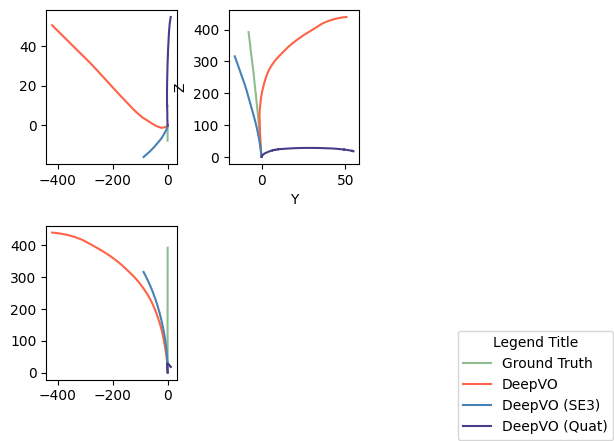

In [5]:

# Load the data
test_sequence='04'
cfg_dir=os.path.join(os.getcwd(),"..","configs","data_loader","KITTI", test_sequence, test_sequence+".yml")
data_loader = DataLoader(SingleDataset(cfg_dir),batch_size=1, shuffle=False, num_workers=0, drop_last=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model
deepvo_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo/original_paper/flownetS", "best-checkpoint-epoch.pth")],
                    conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                    image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
deepvo_se3_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_se3/original_paper/weighted", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
deepvo_quat_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_quat/original_paper/flownetS", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 7, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
# Some auxiliary variables
T_target_relative = list()  

T_deepvo_relative = list()
T_deepvo_se3_relative = list()
T_deepvo_quat_relative = list()

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = deepvo_model(data)

                target = data["poses"]
                deepvo_estimate = deepvo_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. angle axis rotations)
                T_estimate_rel = angle_axis_to_rotation_matrix(deepvo_estimate[:, 1, :3])            
                T_estimate_rel[:,0:3,3] = deepvo_estimate[:,1,-3:]
                T_deepvo_relative.append(T_estimate_rel)
                

        
T_target_absolute = relative_to_absolute_pose(T_target_relative)
T_deepvo_absolute = relative_to_absolute_pose(T_deepvo_relative)

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch

                deepvo_se3_outputs = deepvo_se3_model(data)

                target = data["poses"]
                deepvo_se3_estimate = deepvo_se3_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. se3 rotations)
                T_estimate_se3_rel = se3_exp_map(deepvo_se3_estimate[:, 0, :6])
                T_deepvo_se3_relative.append(T_estimate_se3_rel)

        
T_deepvo_se3_absolute = relative_to_absolute_pose(T_deepvo_se3_relative)

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = deepvo_model(data)
                deepvo_se3_outputs = deepvo_se3_model(data)
                deepvo_quat_outputs = deepvo_quat_model(data)

                target = data["poses"]
                deepvo_quat_estimate = deepvo_quat_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
            
                # for deepvo (w. quaternion rotations)
                T_estimate_quat_rel = torch.eye((4)).reshape(1,4,4)
                q_rotation = quaternion_to_rotation_matrix(deepvo_quat_estimate[:, 0, 3:])
                T_estimate_quat_rel[:,:3,:3] = q_rotation
                T_estimate_quat_rel[:,0:3,3] = deepvo_quat_estimate[:,0,:3]
                T_deepvo_quat_relative.append(T_estimate_quat_rel)

        

T_deepvo_quat_absolute = relative_to_absolute_pose(T_deepvo_quat_relative)
    
plot_route(trajectories=[T_target_absolute, T_deepvo_absolute, T_deepvo_se3_absolute, T_deepvo_quat_absolute], 
           colors=['darkseagreen', 'tomato', 'steelblue', 'darkslateblue'], labels=['Ground Truth', 'DeepVO', 'DeepVO (SE3)', 'DeepVO (Quat)'])           
     


100%|██████████| 2759/2759 [04:32<00:00, 10.13it/s]
/tmp/ipykernel_3913280/133649351.py:27: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([a1, a2, a3],     # The line objects


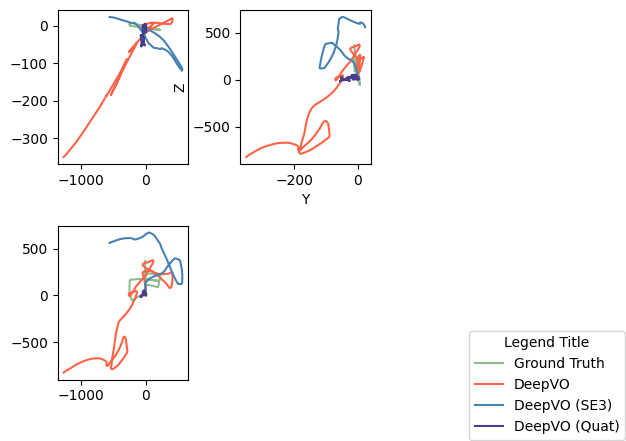

In [6]:

# Load the data
test_sequence='05'
cfg_dir=os.path.join(os.getcwd(),"..","configs","data_loader","KITTI", test_sequence, test_sequence+".yml")
data_loader = DataLoader(SingleDataset(cfg_dir),batch_size=1, shuffle=False, num_workers=0, drop_last=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model
deepvo_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo/original_paper/flownetS", "best-checkpoint-epoch.pth")],
                    conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                    image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
deepvo_se3_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_se3/original_paper/weighted", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
deepvo_quat_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_quat/original_paper/flownetS", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 7, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
# Some auxiliary variables
T_target_relative = list()  

T_deepvo_relative = list()
T_deepvo_se3_relative = list()
T_deepvo_quat_relative = list()

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = deepvo_model(data)

                target = data["poses"]
                deepvo_estimate = deepvo_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. angle axis rotations)
                T_estimate_rel = angle_axis_to_rotation_matrix(deepvo_estimate[:, 1, :3])            
                T_estimate_rel[:,0:3,3] = deepvo_estimate[:,1,-3:]
                T_deepvo_relative.append(T_estimate_rel)
                

        
T_target_absolute = relative_to_absolute_pose(T_target_relative)
T_deepvo_absolute = relative_to_absolute_pose(T_deepvo_relative)

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch

                deepvo_se3_outputs = deepvo_se3_model(data)

                target = data["poses"]
                deepvo_se3_estimate = deepvo_se3_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. se3 rotations)
                T_estimate_se3_rel = se3_exp_map(deepvo_se3_estimate[:, 0, :6])
                T_deepvo_se3_relative.append(T_estimate_se3_rel)

        
T_deepvo_se3_absolute = relative_to_absolute_pose(T_deepvo_se3_relative)

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = deepvo_model(data)
                deepvo_se3_outputs = deepvo_se3_model(data)
                deepvo_quat_outputs = deepvo_quat_model(data)

                target = data["poses"]
                deepvo_quat_estimate = deepvo_quat_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
            
                # for deepvo (w. quaternion rotations)
                T_estimate_quat_rel = torch.eye((4)).reshape(1,4,4)
                q_rotation = quaternion_to_rotation_matrix(deepvo_quat_estimate[:, 0, 3:])
                T_estimate_quat_rel[:,:3,:3] = q_rotation
                T_estimate_quat_rel[:,0:3,3] = deepvo_quat_estimate[:,0,:3]
                T_deepvo_quat_relative.append(T_estimate_quat_rel)

        

T_deepvo_quat_absolute = relative_to_absolute_pose(T_deepvo_quat_relative)
    
plot_route(trajectories=[T_target_absolute, T_deepvo_absolute, T_deepvo_se3_absolute, T_deepvo_quat_absolute], 
           colors=['darkseagreen', 'tomato', 'steelblue', 'darkslateblue'], labels=['Ground Truth', 'DeepVO', 'DeepVO (SE3)', 'DeepVO (Quat)'])           
     


100%|██████████| 1099/1099 [01:47<00:00, 10.22it/s]
/tmp/ipykernel_3913280/133649351.py:27: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([a1, a2, a3],     # The line objects


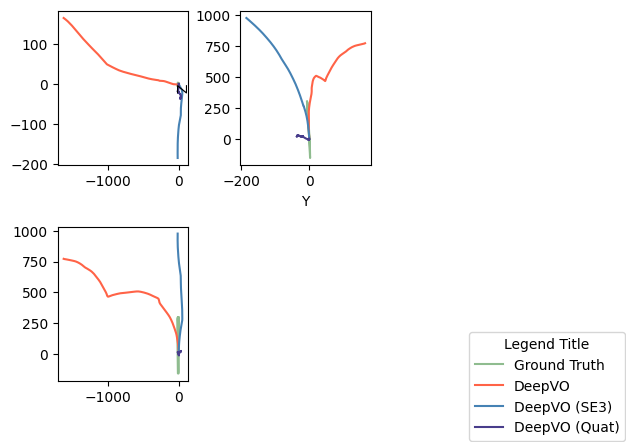

In [7]:

# Load the data
test_sequence='06'
cfg_dir=os.path.join(os.getcwd(),"..","configs","data_loader","KITTI", test_sequence, test_sequence+".yml")
data_loader = DataLoader(SingleDataset(cfg_dir),batch_size=1, shuffle=False, num_workers=0, drop_last=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model
deepvo_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo/original_paper/flownetS", "best-checkpoint-epoch.pth")],
                    conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                    image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
deepvo_se3_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_se3/original_paper/weighted", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
deepvo_quat_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_quat/original_paper/flownetS", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 7, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
# Some auxiliary variables
T_target_relative = list()  

T_deepvo_relative = list()
T_deepvo_se3_relative = list()
T_deepvo_quat_relative = list()

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = deepvo_model(data)

                target = data["poses"]
                deepvo_estimate = deepvo_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. angle axis rotations)
                T_estimate_rel = angle_axis_to_rotation_matrix(deepvo_estimate[:, 1, :3])            
                T_estimate_rel[:,0:3,3] = deepvo_estimate[:,1,-3:]
                T_deepvo_relative.append(T_estimate_rel)
                

        
T_target_absolute = relative_to_absolute_pose(T_target_relative)
T_deepvo_absolute = relative_to_absolute_pose(T_deepvo_relative)

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch

                deepvo_se3_outputs = deepvo_se3_model(data)

                target = data["poses"]
                deepvo_se3_estimate = deepvo_se3_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. se3 rotations)
                T_estimate_se3_rel = se3_exp_map(deepvo_se3_estimate[:, 0, :6])
                T_deepvo_se3_relative.append(T_estimate_se3_rel)

        
T_deepvo_se3_absolute = relative_to_absolute_pose(T_deepvo_se3_relative)

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = deepvo_model(data)
                deepvo_se3_outputs = deepvo_se3_model(data)
                deepvo_quat_outputs = deepvo_quat_model(data)

                target = data["poses"]
                deepvo_quat_estimate = deepvo_quat_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
            
                # for deepvo (w. quaternion rotations)
                T_estimate_quat_rel = torch.eye((4)).reshape(1,4,4)
                q_rotation = quaternion_to_rotation_matrix(deepvo_quat_estimate[:, 0, 3:])
                T_estimate_quat_rel[:,:3,:3] = q_rotation
                T_estimate_quat_rel[:,0:3,3] = deepvo_quat_estimate[:,0,:3]
                T_deepvo_quat_relative.append(T_estimate_quat_rel)

        

T_deepvo_quat_absolute = relative_to_absolute_pose(T_deepvo_quat_relative)
    
plot_route(trajectories=[T_target_absolute, T_deepvo_absolute, T_deepvo_se3_absolute, T_deepvo_quat_absolute], 
           colors=['darkseagreen', 'tomato', 'steelblue', 'darkslateblue'], labels=['Ground Truth', 'DeepVO', 'DeepVO (SE3)', 'DeepVO (Quat)'])           
     


100%|██████████| 1099/1099 [01:48<00:00, 10.11it/s]
/tmp/ipykernel_3913280/133649351.py:27: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([a1, a2, a3],     # The line objects


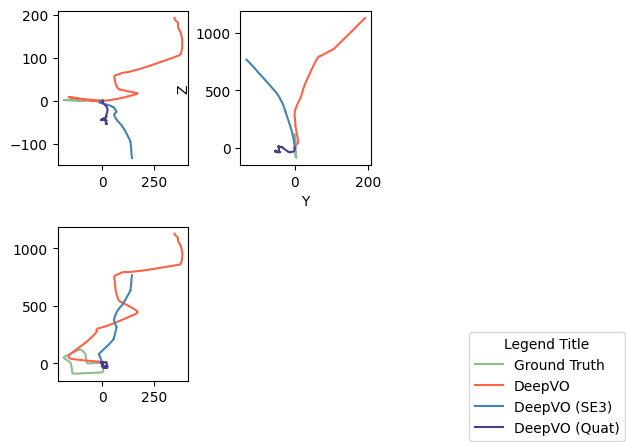

In [8]:

# Load the data
test_sequence='07'
cfg_dir=os.path.join(os.getcwd(),"..","configs","data_loader","KITTI", test_sequence, test_sequence+".yml")
data_loader = DataLoader(SingleDataset(cfg_dir),batch_size=1, shuffle=False, num_workers=0, drop_last=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model
deepvo_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo/original_paper/flownetS", "best-checkpoint-epoch.pth")],
                    conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                    image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
deepvo_se3_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_se3/original_paper/weighted", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
deepvo_quat_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_quat/original_paper/flownetS", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 7, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
# Some auxiliary variables
T_target_relative = list()  

T_deepvo_relative = list()
T_deepvo_se3_relative = list()
T_deepvo_quat_relative = list()

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = deepvo_model(data)

                target = data["poses"]
                deepvo_estimate = deepvo_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. angle axis rotations)
                T_estimate_rel = angle_axis_to_rotation_matrix(deepvo_estimate[:, 1, :3])            
                T_estimate_rel[:,0:3,3] = deepvo_estimate[:,1,-3:]
                T_deepvo_relative.append(T_estimate_rel)
                

        
T_target_absolute = relative_to_absolute_pose(T_target_relative)
T_deepvo_absolute = relative_to_absolute_pose(T_deepvo_relative)

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch

                deepvo_se3_outputs = deepvo_se3_model(data)

                target = data["poses"]
                deepvo_se3_estimate = deepvo_se3_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. se3 rotations)
                T_estimate_se3_rel = se3_exp_map(deepvo_se3_estimate[:, 0, :6])
                T_deepvo_se3_relative.append(T_estimate_se3_rel)

        
T_deepvo_se3_absolute = relative_to_absolute_pose(T_deepvo_se3_relative)

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = deepvo_model(data)
                deepvo_se3_outputs = deepvo_se3_model(data)
                deepvo_quat_outputs = deepvo_quat_model(data)

                target = data["poses"]
                deepvo_quat_estimate = deepvo_quat_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
            
                # for deepvo (w. quaternion rotations)
                T_estimate_quat_rel = torch.eye((4)).reshape(1,4,4)
                q_rotation = quaternion_to_rotation_matrix(deepvo_quat_estimate[:, 0, 3:])
                T_estimate_quat_rel[:,:3,:3] = q_rotation
                T_estimate_quat_rel[:,0:3,3] = deepvo_quat_estimate[:,0,:3]
                T_deepvo_quat_relative.append(T_estimate_quat_rel)

        

T_deepvo_quat_absolute = relative_to_absolute_pose(T_deepvo_quat_relative)
    
plot_route(trajectories=[T_target_absolute, T_deepvo_absolute, T_deepvo_se3_absolute, T_deepvo_quat_absolute], 
           colors=['darkseagreen', 'tomato', 'steelblue', 'darkslateblue'], labels=['Ground Truth', 'DeepVO', 'DeepVO (SE3)', 'DeepVO (Quat)'])           
     


100%|██████████| 4069/4069 [07:08<00:00,  9.49it/s]
/tmp/ipykernel_3913280/133649351.py:27: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([a1, a2, a3],     # The line objects


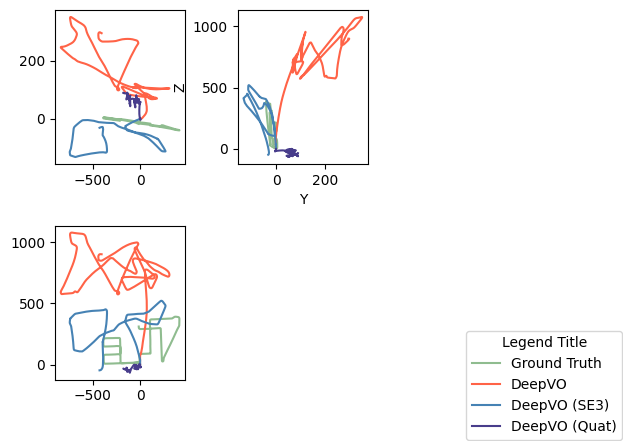

In [12]:
# Load the data
test_sequence='08'
cfg_dir=os.path.join(os.getcwd(),"..","configs","data_loader","KITTI", test_sequence, test_sequence+".yml")
data_loader = DataLoader(SingleDataset(cfg_dir),batch_size=1, shuffle=False, num_workers=0, drop_last=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model
deepvo_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo/original_paper/flownetS", "best-checkpoint-epoch.pth")],
                    conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                    image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
deepvo_se3_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_se3/original_paper/weighted", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
deepvo_quat_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_quat/original_paper/flownetS", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 7, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
# Some auxiliary variables
T_target_relative = list()  

T_deepvo_relative = list()
T_deepvo_se3_relative = list()
T_deepvo_quat_relative = list()

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = deepvo_model(data)

                target = data["poses"]
                deepvo_estimate = deepvo_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. angle axis rotations)
                T_estimate_rel = angle_axis_to_rotation_matrix(deepvo_estimate[:, 1, :3])            
                T_estimate_rel[:,0:3,3] = deepvo_estimate[:,1,-3:]
                T_deepvo_relative.append(T_estimate_rel)
                

        
T_target_absolute = relative_to_absolute_pose(T_target_relative)
T_deepvo_absolute = relative_to_absolute_pose(T_deepvo_relative)

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch

                deepvo_se3_outputs = deepvo_se3_model(data)

                target = data["poses"]
                deepvo_se3_estimate = deepvo_se3_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. se3 rotations)
                T_estimate_se3_rel = se3_exp_map(deepvo_se3_estimate[:, 0, :6])
                T_deepvo_se3_relative.append(T_estimate_se3_rel)

        
T_deepvo_se3_absolute = relative_to_absolute_pose(T_deepvo_se3_relative)

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = deepvo_model(data)
                deepvo_se3_outputs = deepvo_se3_model(data)
                deepvo_quat_outputs = deepvo_quat_model(data)

                target = data["poses"]
                deepvo_quat_estimate = deepvo_quat_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
            
                # for deepvo (w. quaternion rotations)
                T_estimate_quat_rel = torch.eye((4)).reshape(1,4,4)
                q_rotation = quaternion_to_rotation_matrix(deepvo_quat_estimate[:, 0, 3:])
                T_estimate_quat_rel[:,:3,:3] = q_rotation
                T_estimate_quat_rel[:,0:3,3] = deepvo_quat_estimate[:,0,:3]
                T_deepvo_quat_relative.append(T_estimate_quat_rel)

        

T_deepvo_quat_absolute = relative_to_absolute_pose(T_deepvo_quat_relative)
    
plot_route(trajectories=[T_target_absolute, T_deepvo_absolute, T_deepvo_se3_absolute, T_deepvo_quat_absolute], 
           colors=['darkseagreen', 'tomato', 'steelblue', 'darkslateblue'], labels=['Ground Truth', 'DeepVO', 'DeepVO (SE3)', 'DeepVO (Quat)'])           
     


100%|██████████| 4069/4069 [06:41<00:00, 10.12it/s]
/tmp/ipykernel_3913280/133649351.py:27: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([a1, a2, a3],     # The line objects


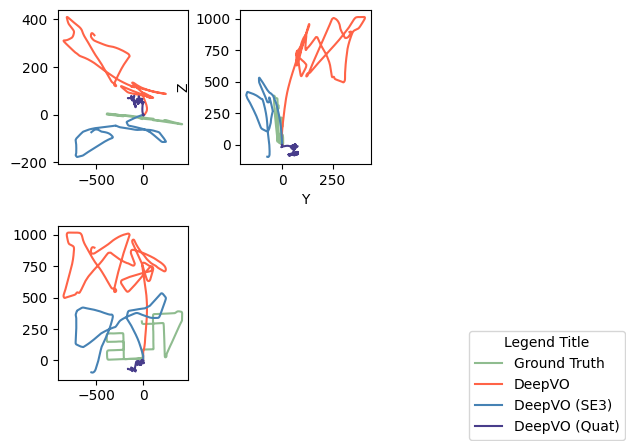

In [ ]:

# Load the data
test_sequence='10'
cfg_dir=os.path.join(os.getcwd(),"..","configs","data_loader","KITTI", test_sequence, test_sequence+".yml")
data_loader = DataLoader(SingleDataset(cfg_dir),batch_size=1, shuffle=False, num_workers=0, drop_last=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model
deepvo_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo/original_paper/flownetS", "best-checkpoint-epoch.pth")],
                    conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                    image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
deepvo_se3_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_se3/original_paper/weighted", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 6, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
deepvo_quat_model = DeepVOModel(batchNorm = True, checkpoint_location=[os.path.join(os.getcwd(),"..","saved/deepvo_quat/original_paper/flownetS", "best-checkpoint-epoch.pth")],
                        conv_dropout = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5],output_shape = 7, 
                        image_size = (371,1241), rnn_hidden_size=1000, rnn_dropout_out=.5, rnn_dropout_between=0).to(device)
# Some auxiliary variables
T_target_relative = list()  

T_deepvo_relative = list()
T_deepvo_se3_relative = list()
T_deepvo_quat_relative = list()

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = deepvo_model(data)

                target = data["poses"]
                deepvo_estimate = deepvo_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. angle axis rotations)
                T_estimate_rel = angle_axis_to_rotation_matrix(deepvo_estimate[:, 1, :3])            
                T_estimate_rel[:,0:3,3] = deepvo_estimate[:,1,-3:]
                T_deepvo_relative.append(T_estimate_rel)
                

        
T_target_absolute = relative_to_absolute_pose(T_target_relative)
T_deepvo_absolute = relative_to_absolute_pose(T_deepvo_relative)

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch

                deepvo_se3_outputs = deepvo_se3_model(data)

                target = data["poses"]
                deepvo_se3_estimate = deepvo_se3_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
                # for deepvo (w. se3 rotations)
                T_estimate_se3_rel = se3_exp_map(deepvo_se3_estimate[:, 0, :6])
                T_deepvo_se3_relative.append(T_estimate_se3_rel)

        
T_deepvo_se3_absolute = relative_to_absolute_pose(T_deepvo_se3_relative)

# Now let's run the model on the data   
with torch.no_grad():     
    for batch_idx, data in tqdm(enumerate(data_loader),total=len(data_loader)):
                # Every data instance is a pair of input data + target result
                data = to_device(data, "cuda:0" if torch.cuda.is_available() else "cpu")
                # Make predictions for this batch
                deepvo_outputs = deepvo_model(data)
                deepvo_se3_outputs = deepvo_se3_model(data)
                deepvo_quat_outputs = deepvo_quat_model(data)

                target = data["poses"]
                deepvo_quat_estimate = deepvo_quat_outputs["result"]

                # Relative values
                T_target_relative.append(target[0])
            
                # for deepvo (w. quaternion rotations)
                T_estimate_quat_rel = torch.eye((4)).reshape(1,4,4)
                q_rotation = quaternion_to_rotation_matrix(deepvo_quat_estimate[:, 0, 3:])
                T_estimate_quat_rel[:,:3,:3] = q_rotation
                T_estimate_quat_rel[:,0:3,3] = deepvo_quat_estimate[:,0,:3]
                T_deepvo_quat_relative.append(T_estimate_quat_rel)

        

T_deepvo_quat_absolute = relative_to_absolute_pose(T_deepvo_quat_relative)
    
plot_route(trajectories=[T_target_absolute, T_deepvo_absolute, T_deepvo_se3_absolute, T_deepvo_quat_absolute], 
           colors=['darkseagreen', 'tomato', 'steelblue', 'darkslateblue'], labels=['Ground Truth', 'DeepVO', 'DeepVO (SE3)', 'DeepVO (Quat)'])           
     
